In [1]:
%load_ext autoreload
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import cv2
import os

In [2]:
video_path = "D:/Movies/360Video/boardroom.mp4"
dataframe_path = video_path.split('.')[0]+'_dataframe.pkl'
fps_extraction = 1

### Clustering Video Faces Using Its Frames

In [3]:
from faces_clustering import VideoClustering

from mtcnn_torch import MTCNN_Torch
from sphere_mtcnn import SphereMTCNN_Torch
from faces_viewport import MTCNN_tf, ViewportsFaceDetector

Using TensorFlow backend.


In [4]:
mtcnn_torch = MTCNN_Torch()
mtcnn_tf = MTCNN_tf()
viewports_torch = ViewportsFaceDetector(torch = True, width = 200, rows = 3, cols = 6, nms_th=0.25)
viewports_tf = ViewportsFaceDetector(torch = False, width = 200, rows = 3, cols = 6, nms_th=0.25)

In [5]:
video_clustering = VideoClustering('senet50', viewports_torch, 'agglomerative', verbose=0)

In [6]:
res = video_clustering.cluster(video_path, fps=fps_extraction)

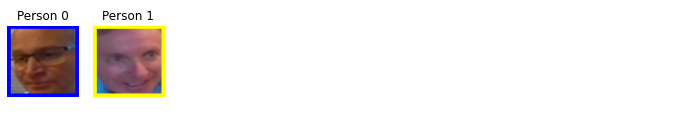

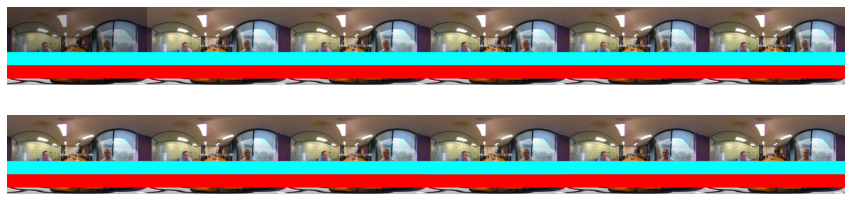

In [7]:
video_clustering.display_timeline(lines = True, limit = 12)

In [8]:
#adjusting and saving dataframe

columns_subtitles = ['frames','urls', 'bounds', video_clustering.cluster_column]
actors_pos =  res[columns_subtitles].copy()
actors_pos.columns = ['frames','urls', 'bounds', 'actors_id']
actors_pos.sort_values(by=['frames'], inplace = True)
actors_pos.reset_index(drop=True, inplace = True)

actors_pos.to_pickle(dataframe_path)

### Positions of Actors

In [9]:
actors_pos = pd.read_pickle(dataframe_path)

In [10]:
#obtaining the center position of the bounding boxes

actors_pos['center_face_pos'] = actors_pos.bounds.apply(lambda x: np.array(x).mean(axis = 0))

actors_pos['bottom_face_pos'] = actors_pos.bounds.apply(lambda x: x[5])

### Converting Coordinates

In [11]:
max_y, max_x, _  = cv2.imread(actors_pos.urls[0]).shape

In [12]:
def lat_long_from_xy(pos_xy, max_x = max_x, max_y = max_y):
    x,y = pos_xy

    d_y = (y/max_y)*180
    d_x = (x/max_x)*360

    lat = d_y-90    #where 90 is the bottom and -90 is the top
    long = d_x - 180  #where 180 is the right and -180 is the left

    return {'lat': lat, 'long': long}

In [13]:
actors_pos['lat_long'] = actors_pos.bottom_face_pos.apply(lat_long_from_xy)

### Time Reference

In [14]:
cap=cv2.VideoCapture(video_path)
original_fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

actors_pos['time'] = actors_pos.frames/original_fps
actors_pos.head()

,frames,urls,bounds,actors_id,center_face_pos,bottom_face_pos,lat_long,time
0,360,D:/Movies/360Video/boardroom\frame_360.jpg,"[(881, 314), (906, 315), (929, 317), (929, 349...",0,"[905.25, 348.875]","(906, 383)","{'lat': 5.75, 'long': 74.81249999999997}",12.0
1,360,D:/Movies/360Video/boardroom\frame_360.jpg,"[(322, 342), (345, 341), (371, 340), (371, 379...",1,"[346.125, 377.5]","(345, 414)","{'lat': 13.499999999999986, 'long': -82.96875}",12.0
2,390,D:/Movies/360Video/boardroom\frame_390.jpg,"[(881, 315), (905, 316), (928, 318), (928, 350...",0,"[904.625, 349.5]","(905, 383)","{'lat': 5.75, 'long': 74.53125}",13.0
3,390,D:/Movies/360Video/boardroom\frame_390.jpg,"[(325, 342), (347, 341), (372, 340), (372, 379...",1,"[348.125, 377.875]","(347, 415)","{'lat': 13.749999999999986, 'long': -82.406249...",13.0
4,420,D:/Movies/360Video/boardroom\frame_420.jpg,"[(883, 313), (907, 314), (929, 316), (929, 349...",0,"[906.25, 348.5]","(907, 383)","{'lat': 5.75, 'long': 75.09375}",14.0


In [15]:
time_reference = actors_pos[['time', 'actors_id','lat_long']].copy()

### Saving position by actors

In [16]:
time_reference.head()

,time,actors_id,lat_long
0,12.0,0,"{'lat': 5.75, 'long': 74.81249999999997}"
1,12.0,1,"{'lat': 13.499999999999986, 'long': -82.96875}"
2,13.0,0,"{'lat': 5.75, 'long': 74.53125}"
3,13.0,1,"{'lat': 13.749999999999986, 'long': -82.406249..."
4,14.0,0,"{'lat': 5.75, 'long': 75.09375}"


In [17]:
def save_actor_positions(actor_id, time_reference, video_path, fps_extraction):
    positions_folder = f"{video_path.split('.')[0]}_actor_positions"
    if not os.path.isdir(positions_folder):
        os.mkdir(positions_folder)

    pos_file_path = f"{positions_folder}/actor_{actor_id}.csv"
    if os.path.exists(pos_file_path):
        print(f'{pos_file_path} already exists! File have not been created.')
        return pos_file_path

    time_positions = time_reference.loc[time_reference.actors_id == actor_id][['time']].copy()
    time_positions['lat'] = time_reference['lat_long'].apply(lambda x: x['lat'])
    time_positions['long'] = time_reference['lat_long'].apply(lambda x: x['long'])


    f = open(pos_file_path, 'a')
    f.write(f'fps_extraction:{fps_extraction}\n')
    time_positions.to_csv(f, index=False)
    f.close()
    return pos_file_path

In [18]:
default_args = [time_reference, video_path, fps_extraction]

_ = save_actor_positions(0, *default_args)
_ = save_actor_positions(1, *default_args)